# Burgers' Equation and Shock Wave Formation

## Introduction

Burgers' equation is a fundamental partial differential equation that serves as a simplified model for understanding nonlinear wave phenomena, including shock wave formation. It combines nonlinear advection with diffusion and appears in various applications from fluid dynamics to traffic flow modeling.

## Mathematical Formulation

### The Viscous Burgers' Equation

The one-dimensional viscous Burgers' equation is given by:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

where:
- $u(x, t)$ is the velocity field
- $\nu \geq 0$ is the kinematic viscosity (diffusion coefficient)
- The term $u \frac{\partial u}{\partial x}$ represents nonlinear advection
- The term $\nu \frac{\partial^2 u}{\partial x^2}$ represents diffusion

### The Inviscid Burgers' Equation

When $\nu = 0$, we obtain the inviscid Burgers' equation:

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0$$

This hyperbolic equation can be written in conservation form:

$$\frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\left(\frac{u^2}{2}\right) = 0$$

## Shock Wave Formation

### Method of Characteristics

For the inviscid equation, characteristics are curves along which $u$ remains constant. The characteristic equations are:

$$\frac{dx}{dt} = u, \quad \frac{du}{dt} = 0$$

This means characteristics are straight lines with slope equal to the local velocity $u$.

### Breaking Time

When characteristics intersect, a shock forms. For an initial condition $u(x, 0) = u_0(x)$, the breaking time $t_b$ (time of first shock formation) is:

$$t_b = -\frac{1}{\min\left(\frac{du_0}{dx}\right)}$$

provided $\frac{du_0}{dx} < 0$ somewhere (compressive initial data).

### Rankine-Hugoniot Condition

Once a shock forms, it propagates with speed $s$ given by the Rankine-Hugoniot jump condition:

$$s = \frac{u_L + u_R}{2}$$

where $u_L$ and $u_R$ are the values on the left and right of the shock.

## Numerical Methods

We will implement several numerical schemes to solve Burgers' equation and observe shock formation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy.ndimage import convolve1d

# Set up plotting style
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
plt.rcParams['lines.linewidth'] = 2

## Numerical Implementation

### 1. Lax-Friedrichs Scheme (Conservative)

The Lax-Friedrichs scheme is a first-order accurate, stable scheme for conservation laws:

$$u_j^{n+1} = \frac{1}{2}(u_{j+1}^n + u_{j-1}^n) - \frac{\Delta t}{2\Delta x}\left(f_{j+1}^n - f_{j-1}^n\right)$$

where $f(u) = \frac{u^2}{2}$ is the flux function.

In [2]:
def burgers_flux(u):
    """Flux function for Burgers' equation: f(u) = u^2/2"""
    return 0.5 * u**2

def lax_friedrichs(u, dx, dt):
    """
    One time step using Lax-Friedrichs scheme.
    
    Parameters:
    -----------
    u : ndarray
        Current solution
    dx : float
        Spatial step size
    dt : float
        Time step size
    
    Returns:
    --------
    u_new : ndarray
        Solution after one time step
    """
    f = burgers_flux(u)
    u_new = np.zeros_like(u)
    
    # Interior points
    u_new[1:-1] = 0.5 * (u[2:] + u[:-2]) - (dt / (2 * dx)) * (f[2:] - f[:-2])
    
    # Periodic boundary conditions
    u_new[0] = 0.5 * (u[1] + u[-1]) - (dt / (2 * dx)) * (f[1] - f[-1])
    u_new[-1] = u_new[0]
    
    return u_new

### 2. Godunov Scheme with Exact Riemann Solver

The Godunov scheme uses the solution of Riemann problems at cell interfaces. For Burgers' equation, the exact Riemann solver gives:

$$u^*(0) = \begin{cases}
u_L & \text{if } u_L \geq u_R \text{ and } s \geq 0 \\
u_R & \text{if } u_L \geq u_R \text{ and } s < 0 \\
u_L & \text{if } u_L < u_R \text{ and } u_L > 0 \\
0 & \text{if } u_L < u_R \text{ and } u_L \leq 0 \leq u_R \\
u_R & \text{if } u_L < u_R \text{ and } u_R < 0
\end{cases}$$

In [3]:
def riemann_solver_burgers(u_L, u_R):
    """
    Exact Riemann solver for Burgers' equation.
    Returns the flux at the interface.
    """
    if u_L >= u_R:  # Shock
        s = 0.5 * (u_L + u_R)  # Shock speed
        if s >= 0:
            return burgers_flux(u_L)
        else:
            return burgers_flux(u_R)
    else:  # Rarefaction
        if u_L > 0:
            return burgers_flux(u_L)
        elif u_R < 0:
            return burgers_flux(u_R)
        else:
            return 0.0

def godunov(u, dx, dt):
    """
    One time step using Godunov scheme with exact Riemann solver.
    """
    n = len(u)
    flux = np.zeros(n + 1)
    
    # Compute fluxes at interfaces
    for i in range(n):
        u_L = u[i]
        u_R = u[(i + 1) % n]
        flux[i + 1] = riemann_solver_burgers(u_L, u_R)
    flux[0] = flux[n]  # Periodic BC
    
    # Update solution
    u_new = u - (dt / dx) * (flux[1:n+1] - flux[0:n])
    
    return u_new

### 3. Viscous Burgers' Equation Solver

For the viscous case, we use operator splitting:
1. Solve the advection part using Godunov
2. Solve the diffusion part using implicit Euler

In [4]:
def solve_diffusion_implicit(u, dx, dt, nu):
    """
    Solve the diffusion equation du/dt = nu * d^2u/dx^2
    using implicit Euler with periodic BCs.
    """
    n = len(u)
    r = nu * dt / dx**2
    
    # Build tridiagonal matrix for periodic BCs
    # (I - r*L) u_new = u
    main_diag = (1 + 2*r) * np.ones(n)
    off_diag = -r * np.ones(n - 1)
    
    # Use Thomas algorithm with periodic modification
    # For simplicity, use numpy's linear algebra solver
    A = np.diag(main_diag) + np.diag(off_diag, 1) + np.diag(off_diag, -1)
    A[0, -1] = -r  # Periodic BC
    A[-1, 0] = -r  # Periodic BC
    
    u_new = np.linalg.solve(A, u)
    return u_new

def burgers_viscous(u, dx, dt, nu):
    """
    One time step for viscous Burgers' equation using operator splitting.
    """
    # Advection step
    u_star = godunov(u, dx, dt)
    
    # Diffusion step
    if nu > 0:
        u_new = solve_diffusion_implicit(u_star, dx, dt, nu)
    else:
        u_new = u_star
    
    return u_new

## Simulation Setup

We'll study shock formation using a sinusoidal initial condition:

$$u_0(x) = \sin(2\pi x)$$

on the domain $[0, 1]$ with periodic boundary conditions.

For this initial condition, $\frac{du_0}{dx} = 2\pi\cos(2\pi x)$, which has minimum value $-2\pi$ at $x = 0.5$.

Therefore, the breaking time is:

$$t_b = \frac{1}{2\pi} \approx 0.159$$

In [5]:
# Domain and grid parameters
L = 1.0           # Domain length
N = 200           # Number of grid points
dx = L / N        # Spatial step
x = np.linspace(0, L - dx, N)  # Grid points (periodic)

# Time parameters
T_final = 0.5     # Final time
CFL = 0.5         # CFL number for stability

# Initial condition: sinusoidal
def initial_condition(x):
    return np.sin(2 * np.pi * x)

# Calculate theoretical breaking time
t_break = 1 / (2 * np.pi)
print(f"Theoretical breaking time: t_b = {t_break:.4f}")

Theoretical breaking time: t_b = 0.1592


## Demonstration 1: Shock Formation in Inviscid Burgers' Equation

Let's visualize how a smooth initial condition develops into a shock wave.

In [6]:
def simulate_burgers(u0, dx, T_final, nu=0, scheme='godunov', CFL=0.5):
    """
    Simulate Burgers' equation and return solutions at various times.
    
    Parameters:
    -----------
    u0 : ndarray
        Initial condition
    dx : float
        Spatial step
    T_final : float
        Final simulation time
    nu : float
        Viscosity coefficient (0 for inviscid)
    scheme : str
        'godunov' or 'lax_friedrichs'
    CFL : float
        CFL number
    
    Returns:
    --------
    times : list
        Time values
    solutions : list
        Solution arrays at each time
    """
    u = u0.copy()
    t = 0
    
    # Store snapshots
    times = [0]
    solutions = [u0.copy()]
    snapshot_times = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
    
    while t < T_final:
        # Adaptive time step based on CFL condition
        u_max = np.max(np.abs(u))
        if u_max < 1e-10:
            u_max = 1.0
        dt = CFL * dx / u_max
        
        if t + dt > T_final:
            dt = T_final - t
        
        # Time stepping
        if nu > 0:
            u = burgers_viscous(u, dx, dt, nu)
        elif scheme == 'godunov':
            u = godunov(u, dx, dt)
        else:
            u = lax_friedrichs(u, dx, dt)
        
        t += dt
        
        # Save snapshots
        for st in snapshot_times:
            if abs(t - st) < dt/2 and st not in times:
                times.append(st)
                solutions.append(u.copy())
    
    # Ensure final time is included
    if times[-1] < T_final - 1e-10:
        times.append(T_final)
        solutions.append(u.copy())
    
    return times, solutions

# Run simulation for inviscid case
u0 = initial_condition(x)
times_inv, solutions_inv = simulate_burgers(u0, dx, T_final, nu=0, scheme='godunov')

print(f"Simulation completed. Captured {len(times_inv)} snapshots.")

Simulation completed. Captured 8 snapshots.


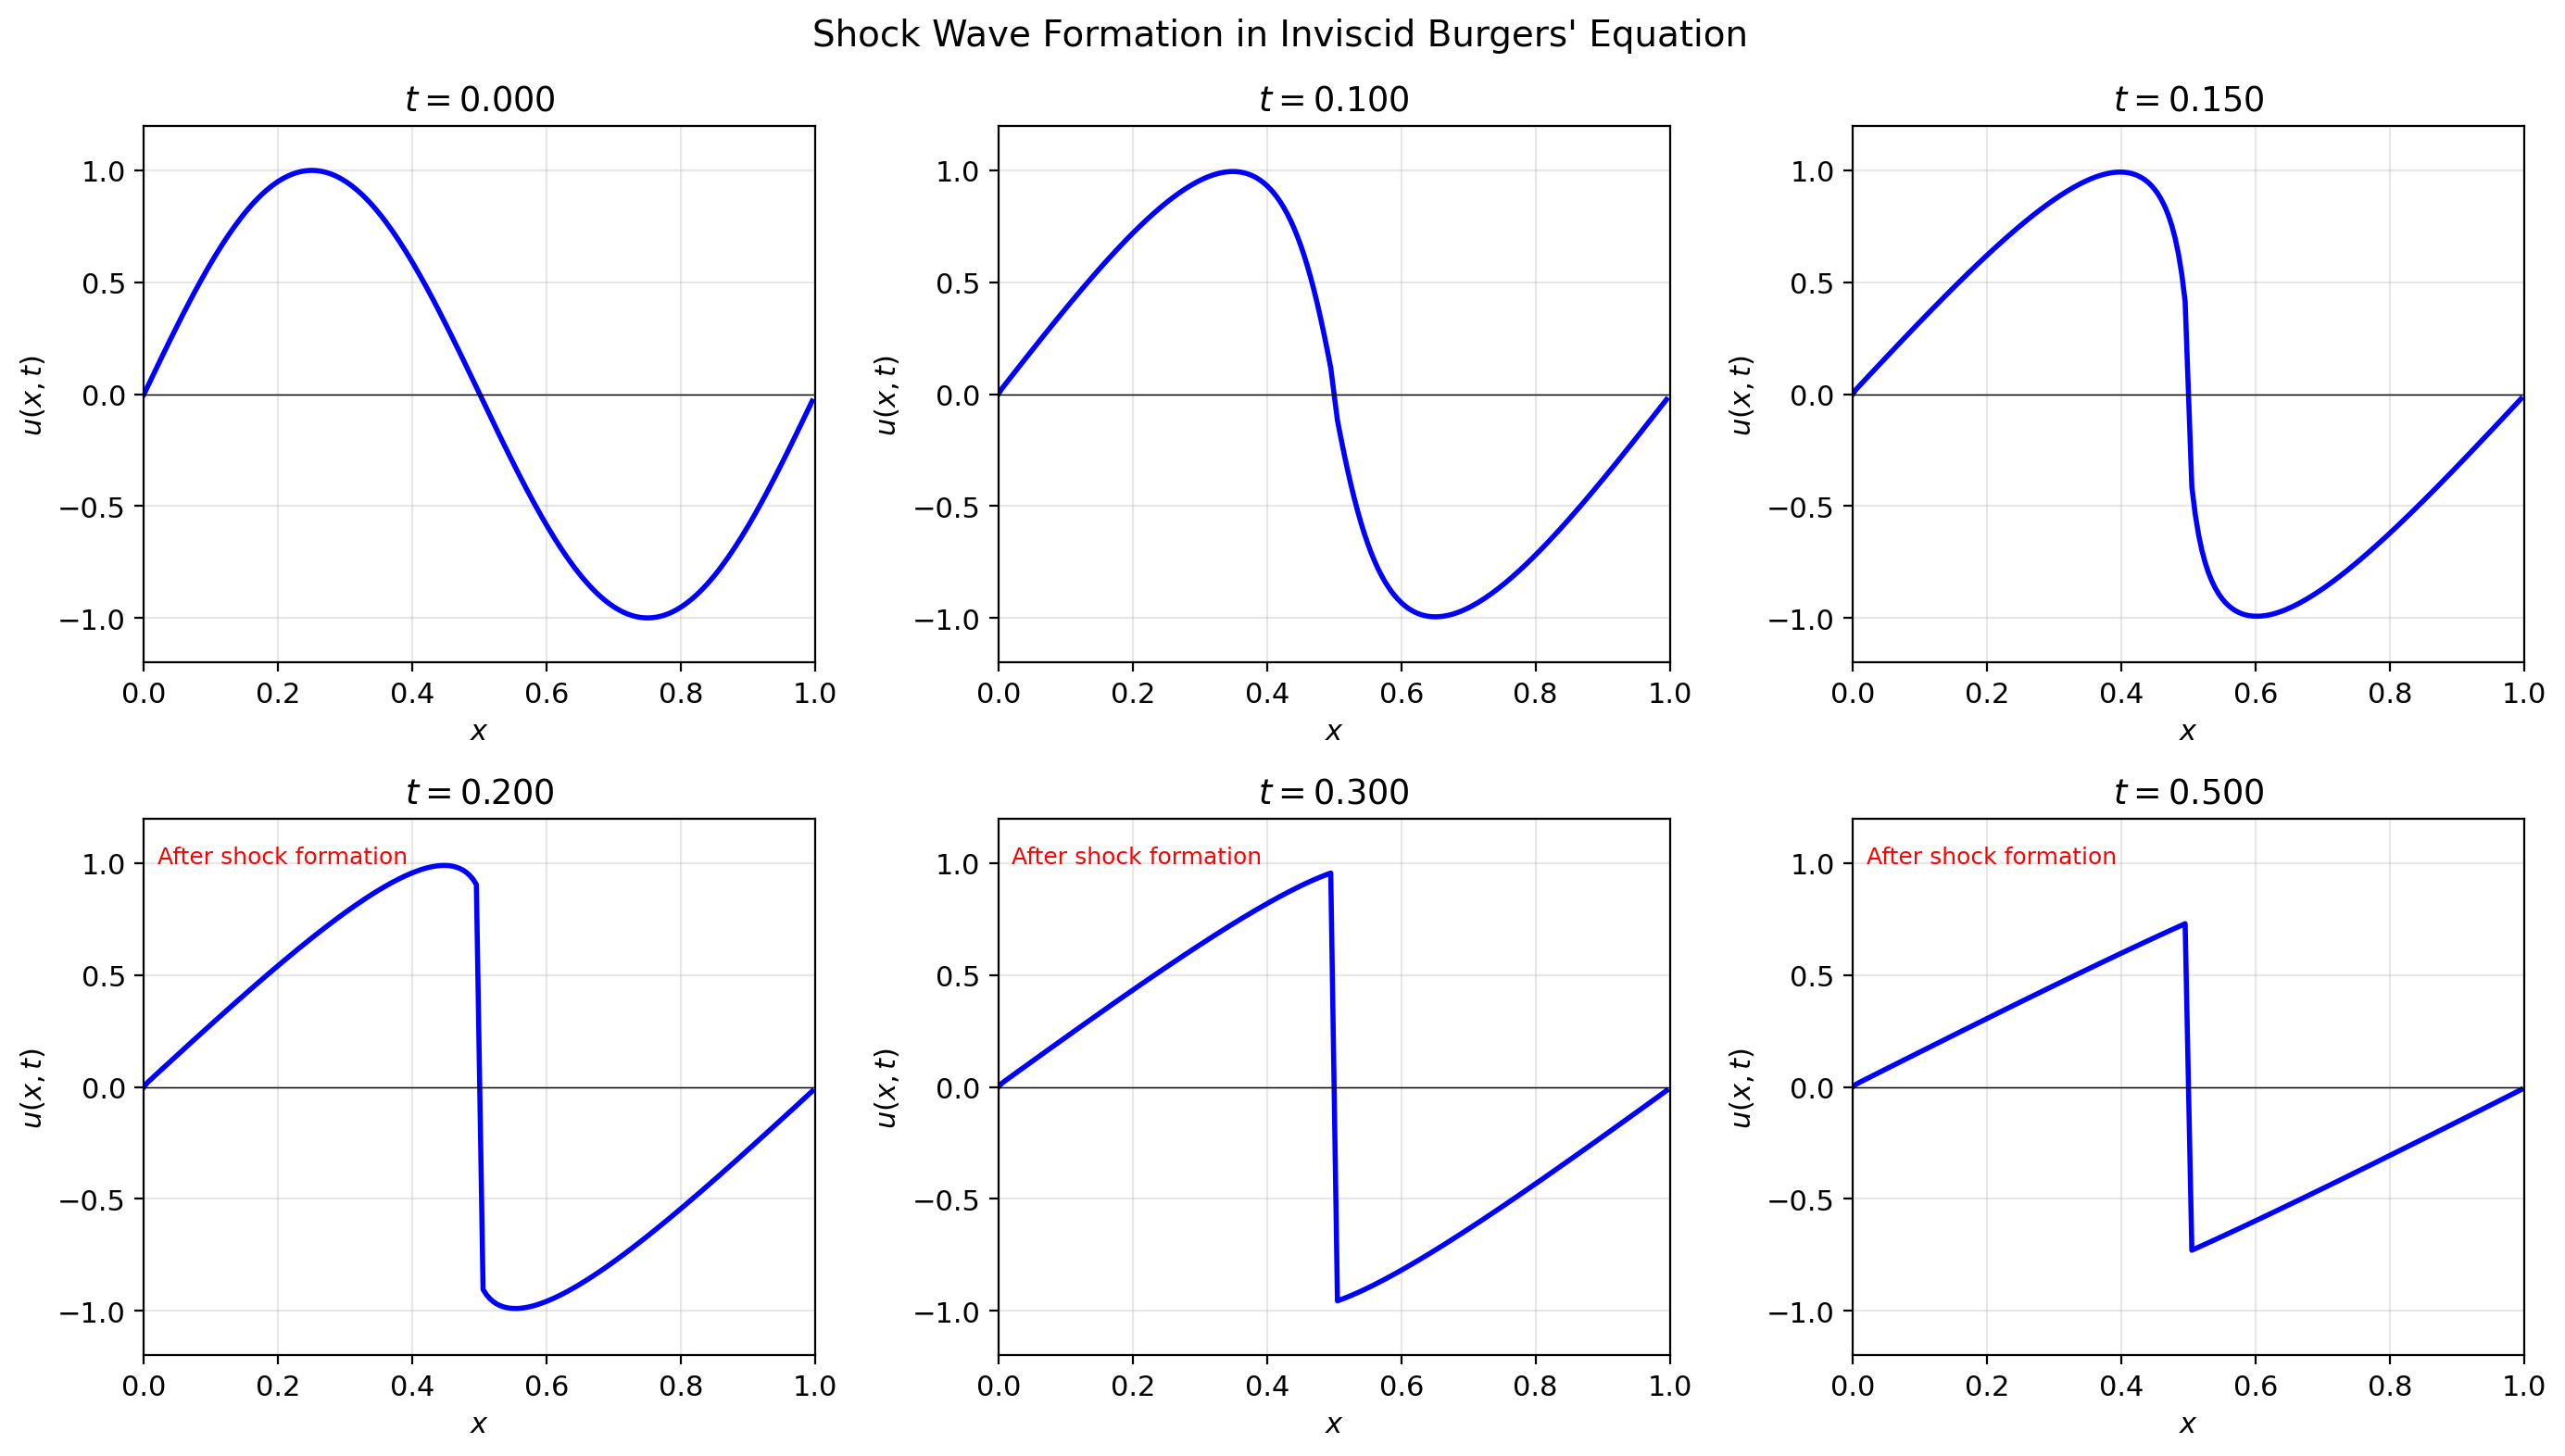

In [7]:
# Plot shock formation
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

plot_times = [0, 0.1, 0.15, 0.2, 0.3, 0.5]

for idx, t_plot in enumerate(plot_times):
    # Find closest snapshot
    i = np.argmin([abs(t - t_plot) for t in times_inv])
    
    ax = axes[idx]
    ax.plot(x, solutions_inv[i], 'b-', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x, t)$')
    ax.set_title(f'$t = {times_inv[i]:.3f}$')
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    ax.grid(True, alpha=0.3)
    
    # Mark breaking time
    if times_inv[i] >= t_break:
        ax.text(0.02, 0.95, 'After shock formation', 
                transform=ax.transAxes, fontsize=9,
                verticalalignment='top', color='red')

plt.suptitle('Shock Wave Formation in Inviscid Burgers\' Equation', fontsize=14)
plt.tight_layout()
plt.show()

## Demonstration 2: Method of Characteristics

Let's visualize the characteristic lines to understand shock formation geometrically.

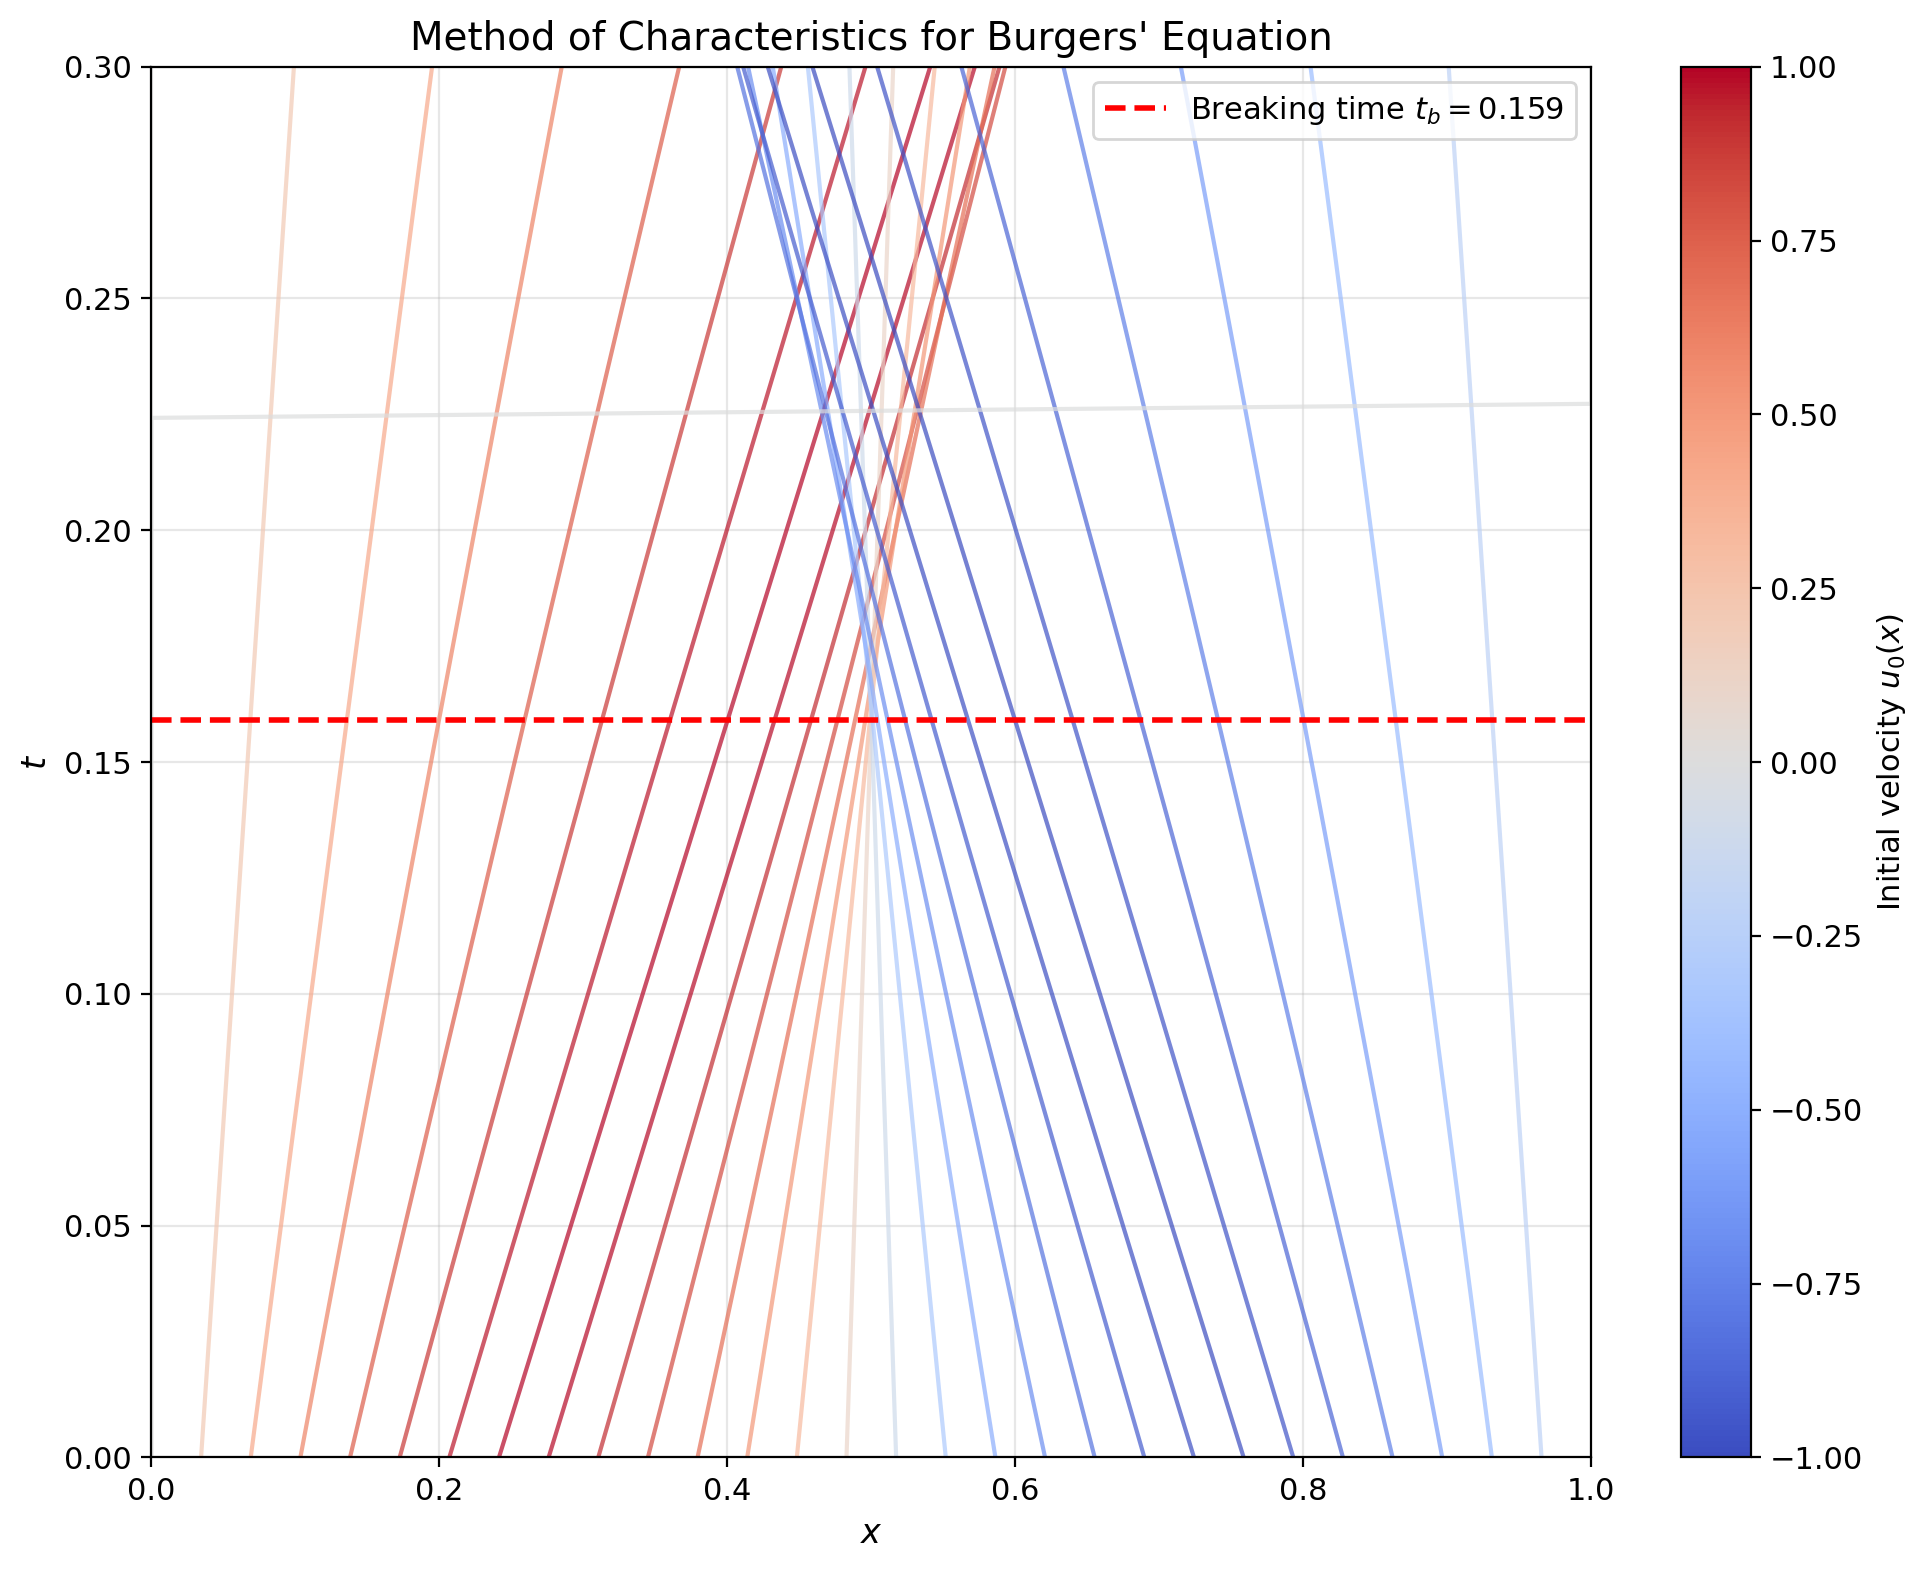

In [8]:
# Plot characteristics
fig, ax = plt.subplots(figsize=(10, 8))

# Initial positions and velocities
n_chars = 30
x0_chars = np.linspace(0, 1, n_chars)
u0_chars = initial_condition(x0_chars)

# Time range
t_range = np.linspace(0, 0.3, 100)

# Plot characteristics
for i in range(n_chars):
    x_char = x0_chars[i] + u0_chars[i] * t_range
    # Wrap around for periodic domain
    x_char = x_char % 1.0
    
    # Color based on initial velocity
    color = plt.cm.coolwarm((u0_chars[i] + 1) / 2)
    ax.plot(x_char, t_range, '-', color=color, linewidth=1.5, alpha=0.7)

# Mark breaking time
ax.axhline(y=t_break, color='red', linestyle='--', linewidth=2, label=f'Breaking time $t_b = {t_break:.3f}$')

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$t$', fontsize=12)
ax.set_title('Method of Characteristics for Burgers\' Equation', fontsize=14)
ax.set_xlim([0, 1])
ax.set_ylim([0, 0.3])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(-1, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Initial velocity $u_0(x)$')

plt.tight_layout()
plt.show()

## Demonstration 3: Effect of Viscosity

Compare solutions with different viscosity values. Higher viscosity smooths the shock.

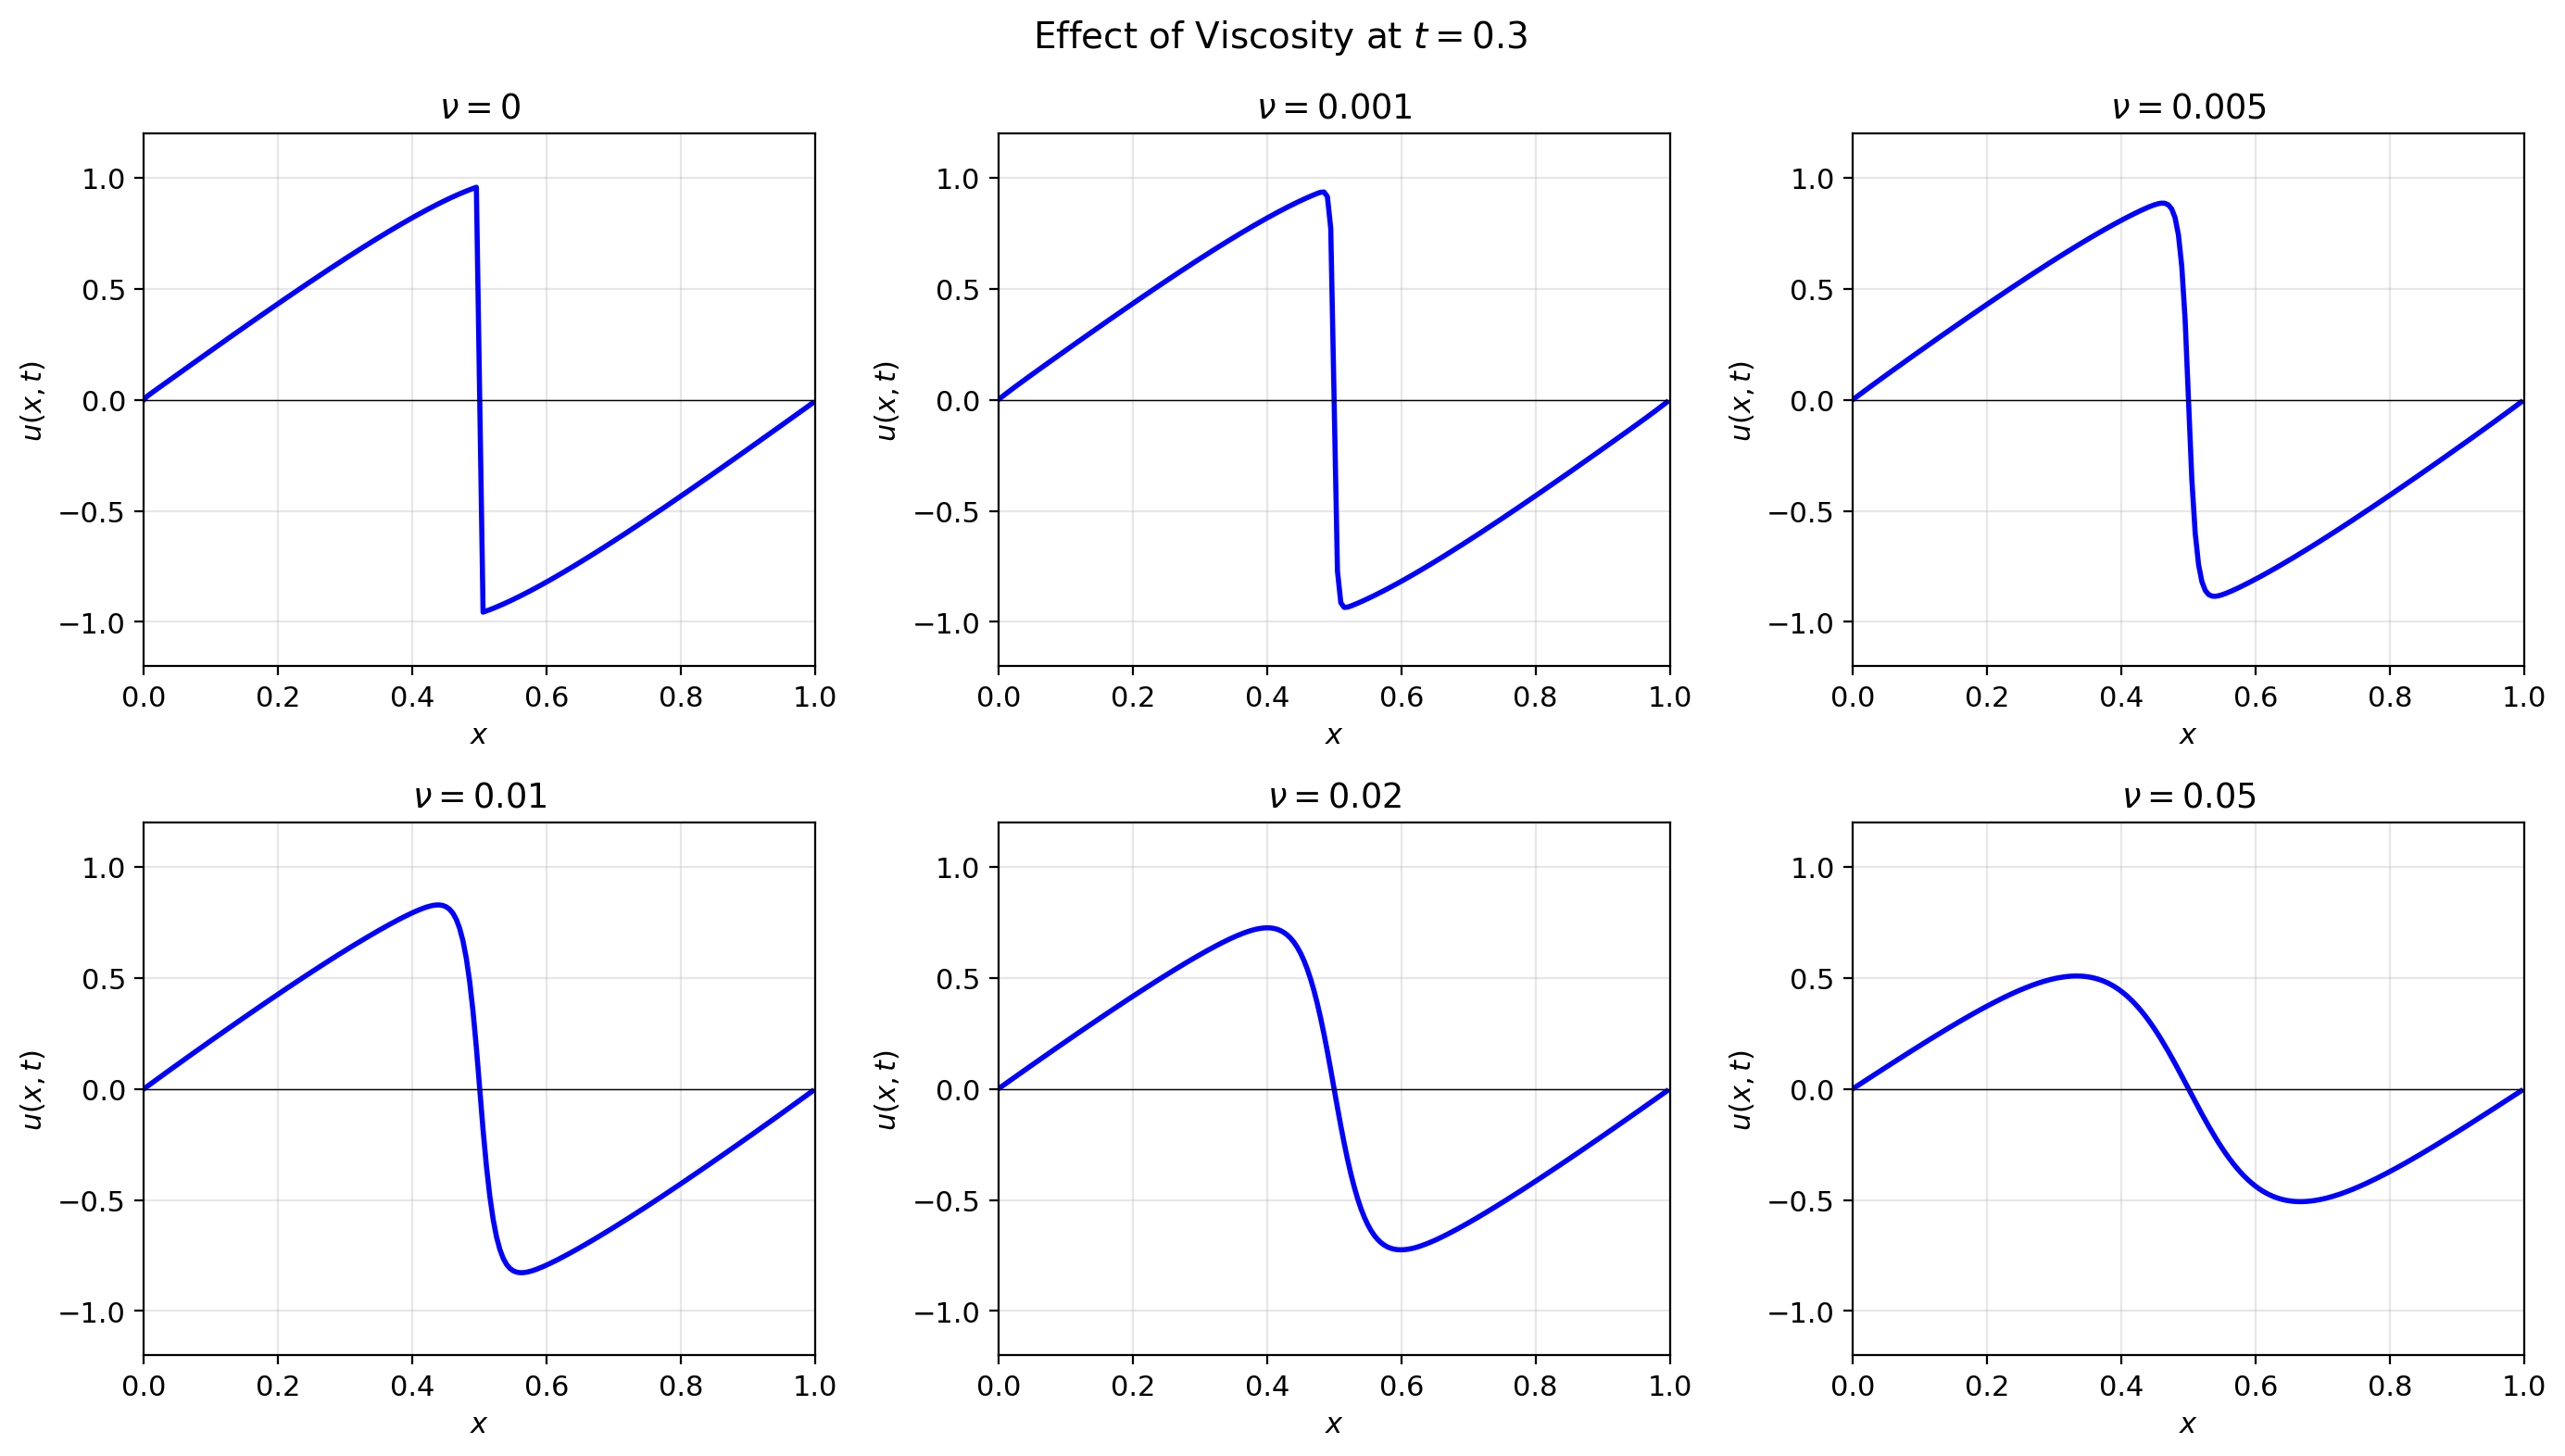

In [9]:
# Compare different viscosity values
viscosities = [0, 0.001, 0.005, 0.01, 0.02, 0.05]
T_compare = 0.3

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, nu in enumerate(viscosities):
    times, solutions = simulate_burgers(u0, dx, T_compare, nu=nu)
    
    ax = axes[idx]
    ax.plot(x, solutions[-1], 'b-', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x, t)$')
    ax.set_title(f'$\\nu = {nu}$')
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Effect of Viscosity at $t = {T_compare}$', fontsize=14)
plt.tight_layout()
plt.show()

## Demonstration 4: Comparison of Numerical Schemes

Compare Lax-Friedrichs and Godunov schemes for shock capturing.

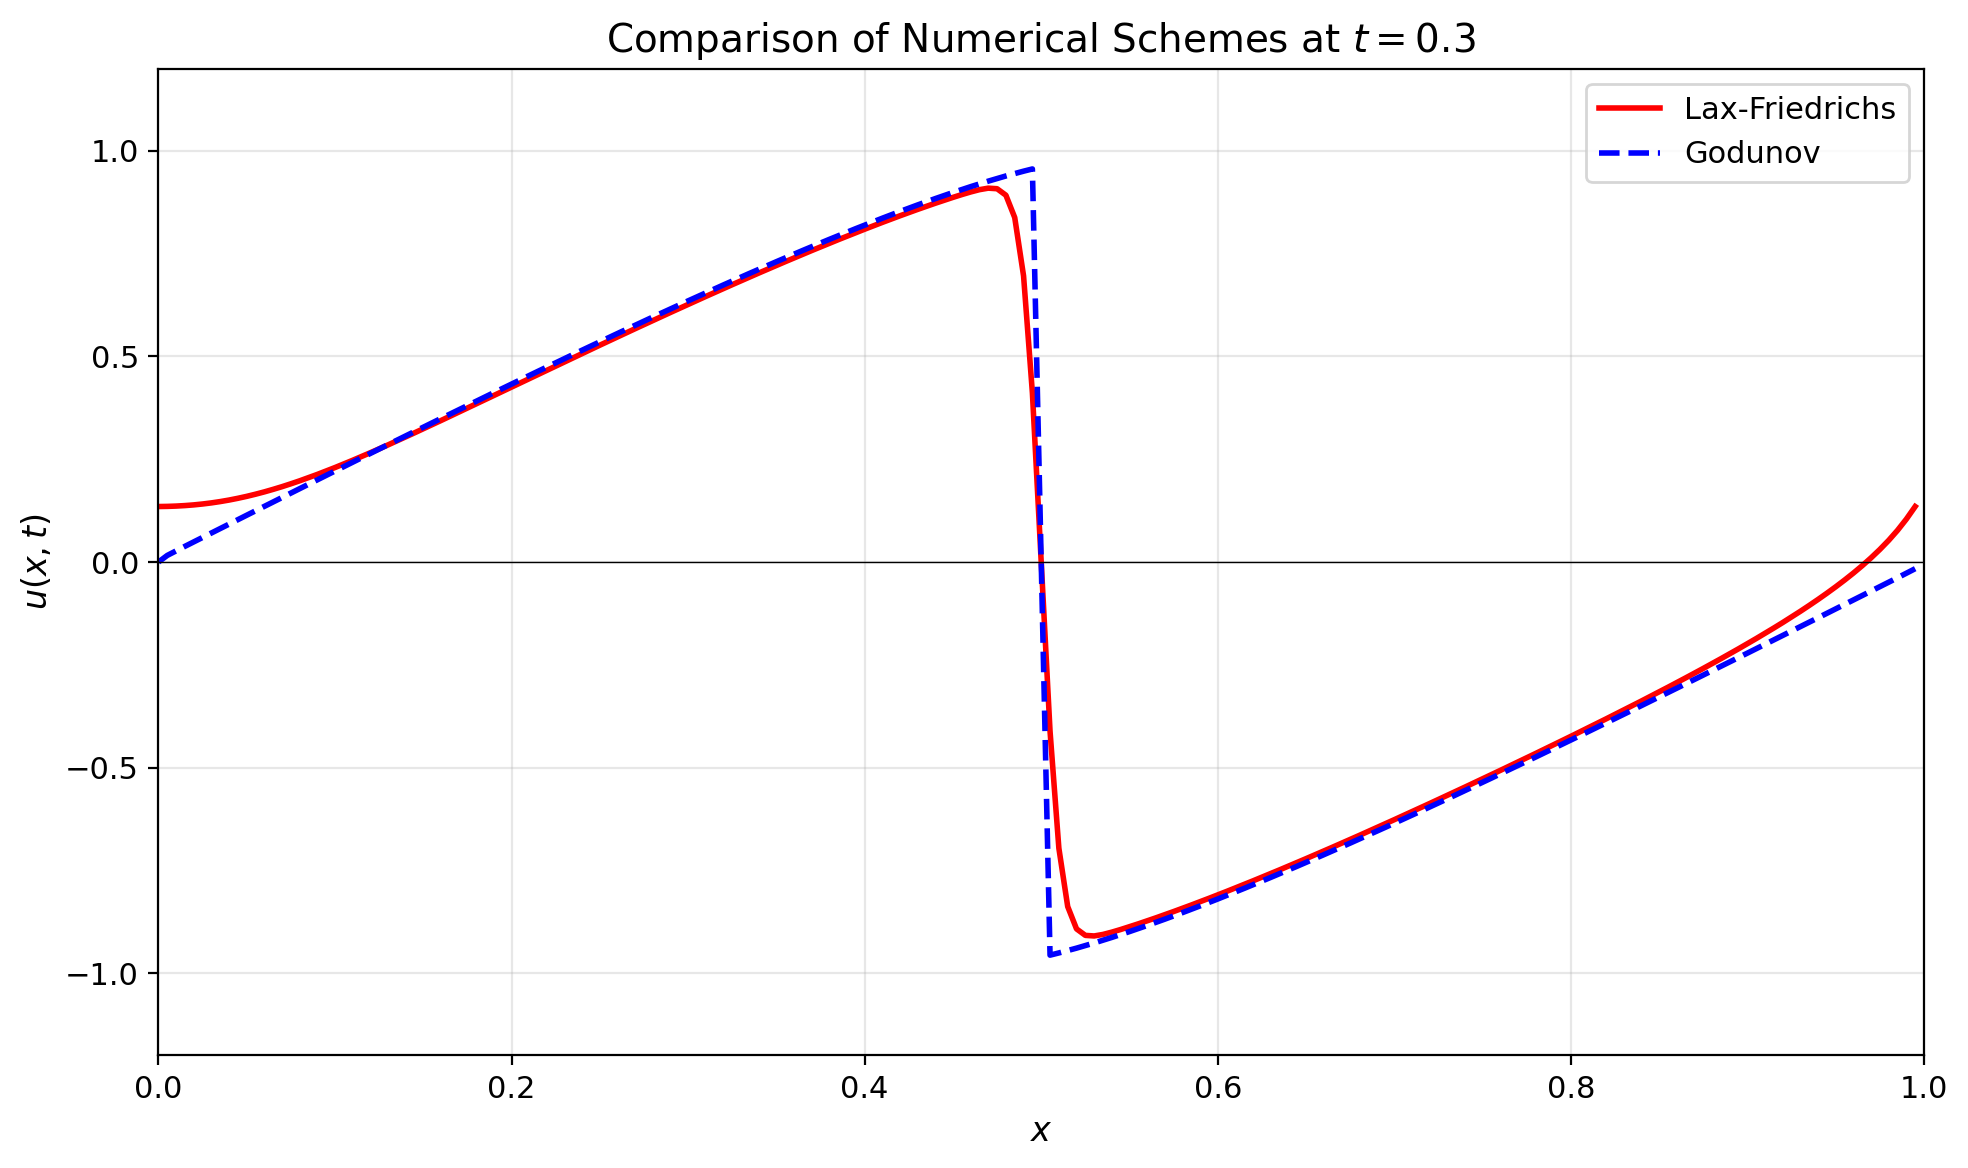

In [10]:
# Compare schemes
T_compare = 0.3

times_lf, solutions_lf = simulate_burgers(u0, dx, T_compare, nu=0, scheme='lax_friedrichs')
times_god, solutions_god = simulate_burgers(u0, dx, T_compare, nu=0, scheme='godunov')

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, solutions_lf[-1], 'r-', linewidth=2, label='Lax-Friedrichs')
ax.plot(x, solutions_god[-1], 'b--', linewidth=2, label='Godunov')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel('$u(x, t)$', fontsize=12)
ax.set_title(f'Comparison of Numerical Schemes at $t = {T_compare}$', fontsize=14)
ax.set_xlim([0, 1])
ax.set_ylim([-1.2, 1.2])
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Demonstration 5: Riemann Problem

The Riemann problem is the initial value problem with piecewise constant initial data:

$$u_0(x) = \begin{cases} u_L & x < 0 \\ u_R & x > 0 \end{cases}$$

- If $u_L > u_R$: Shock wave (characteristics collide)
- If $u_L < u_R$: Rarefaction wave (characteristics diverge)

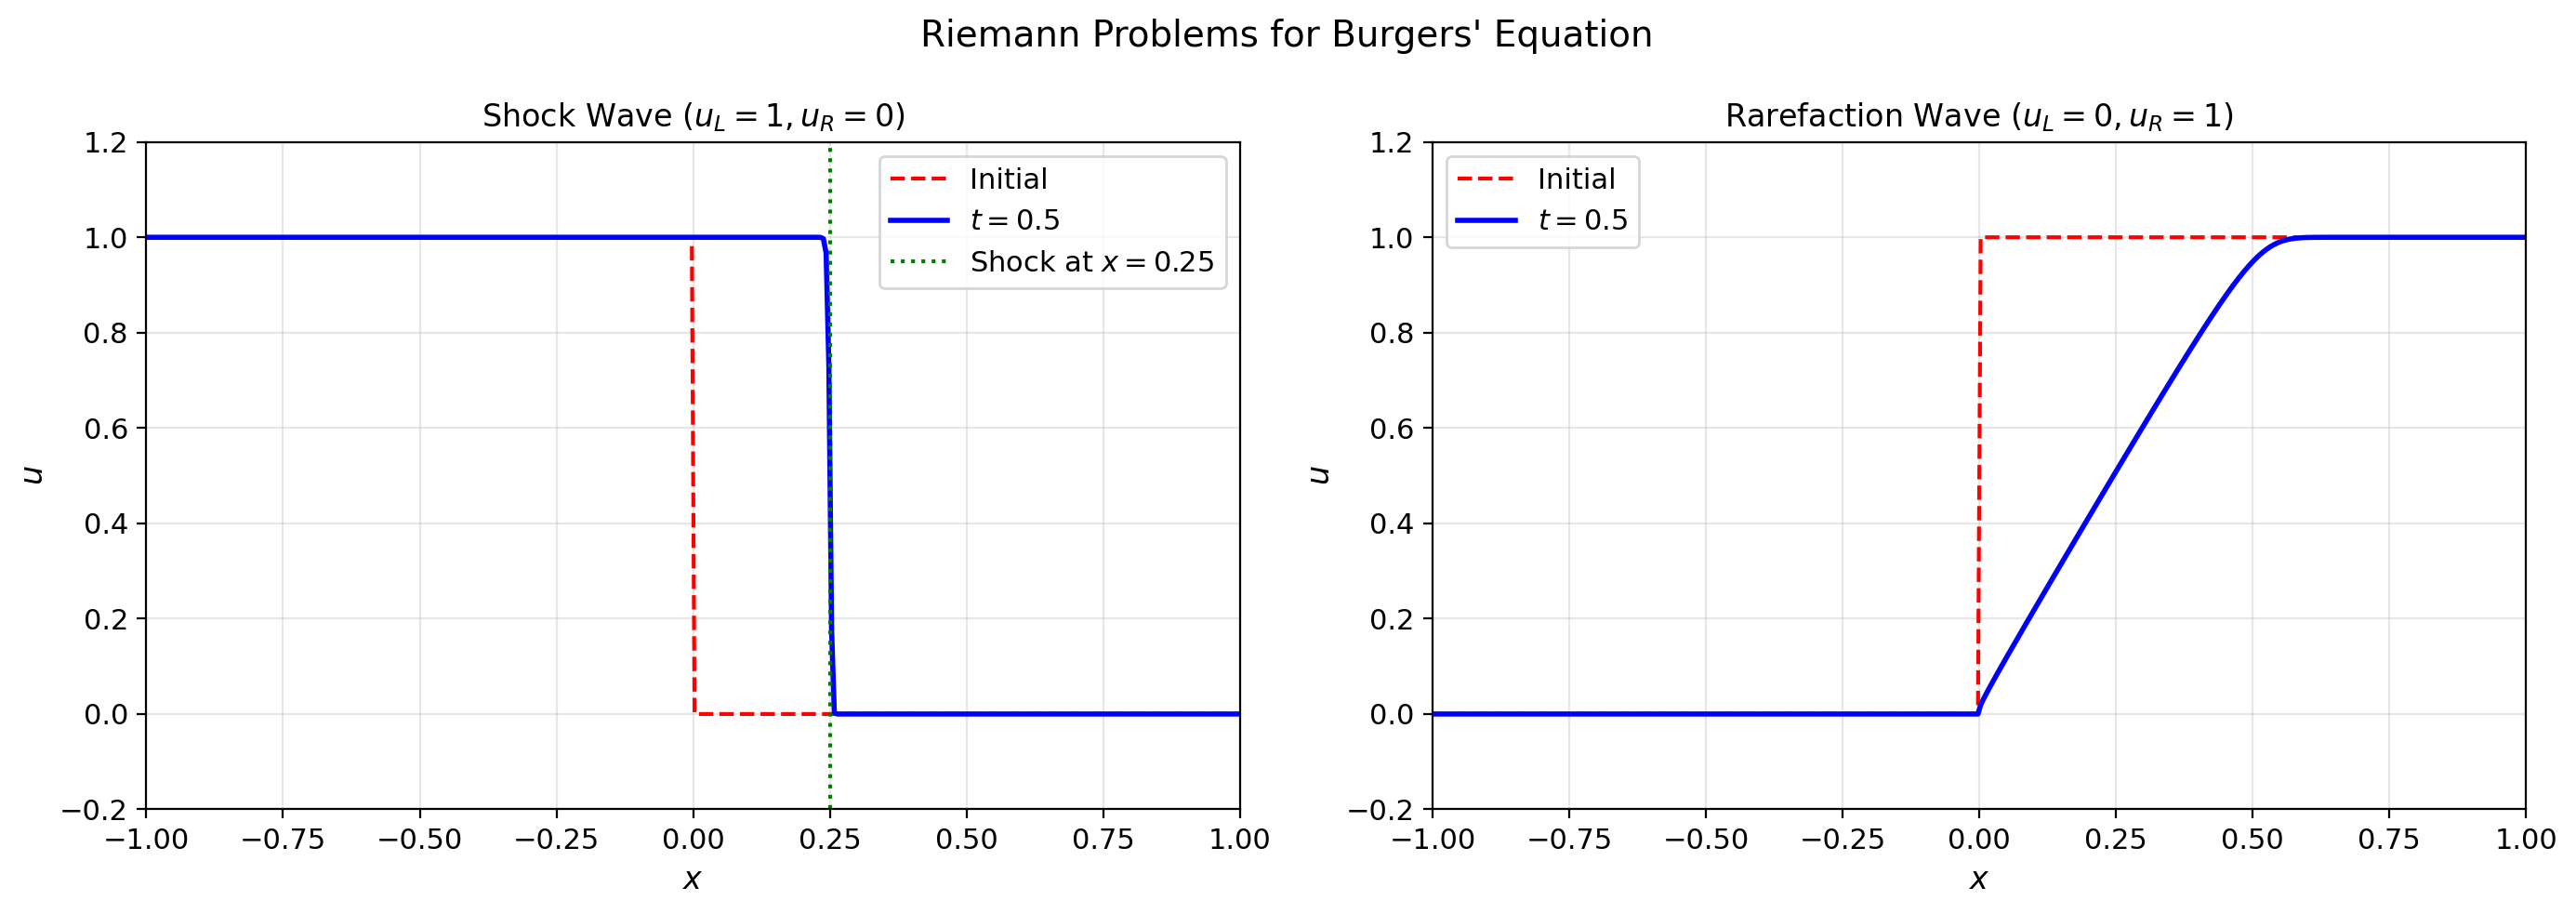

In [11]:
# Riemann problem setup
N_riemann = 400
x_riemann = np.linspace(-1, 1, N_riemann)
dx_riemann = x_riemann[1] - x_riemann[0]

def riemann_initial(x, u_L, u_R):
    """Riemann problem initial condition."""
    return np.where(x < 0, u_L, u_R)

def simulate_riemann(u_L, u_R, T_final, dx, x_grid):
    """Simulate Riemann problem."""
    u = riemann_initial(x_grid, u_L, u_R)
    t = 0
    CFL = 0.5
    
    while t < T_final:
        u_max = max(abs(u_L), abs(u_R), 0.1)
        dt = CFL * dx / u_max
        
        if t + dt > T_final:
            dt = T_final - t
        
        # Use Godunov with outflow BCs
        n = len(u)
        flux = np.zeros(n + 1)
        
        for i in range(n - 1):
            flux[i + 1] = riemann_solver_burgers(u[i], u[i + 1])
        flux[0] = burgers_flux(u[0])   # Outflow BC
        flux[n] = burgers_flux(u[-1])  # Outflow BC
        
        u = u - (dt / dx) * (flux[1:n+1] - flux[0:n])
        t += dt
    
    return u

# Case 1: Shock wave (u_L > u_R)
u_L_shock, u_R_shock = 1.0, 0.0
u_shock = simulate_riemann(u_L_shock, u_R_shock, 0.5, dx_riemann, x_riemann)

# Case 2: Rarefaction wave (u_L < u_R)
u_L_rare, u_R_rare = 0.0, 1.0
u_rare = simulate_riemann(u_L_rare, u_R_rare, 0.5, dx_riemann, x_riemann)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Shock wave
axes[0].plot(x_riemann, riemann_initial(x_riemann, u_L_shock, u_R_shock), 
             'r--', linewidth=1.5, label='Initial')
axes[0].plot(x_riemann, u_shock, 'b-', linewidth=2, label='$t = 0.5$')

# Analytical shock position
s_shock = 0.5 * (u_L_shock + u_R_shock)
x_shock_pos = s_shock * 0.5
axes[0].axvline(x=x_shock_pos, color='g', linestyle=':', linewidth=1.5, 
                label=f'Shock at $x = {x_shock_pos:.2f}$')

axes[0].set_xlabel('$x$', fontsize=12)
axes[0].set_ylabel('$u$', fontsize=12)
axes[0].set_title('Shock Wave ($u_L = 1, u_R = 0$)', fontsize=12)
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([-1, 1])
axes[0].set_ylim([-0.2, 1.2])

# Rarefaction wave
axes[1].plot(x_riemann, riemann_initial(x_riemann, u_L_rare, u_R_rare), 
             'r--', linewidth=1.5, label='Initial')
axes[1].plot(x_riemann, u_rare, 'b-', linewidth=2, label='$t = 0.5$')

axes[1].set_xlabel('$x$', fontsize=12)
axes[1].set_ylabel('$u$', fontsize=12)
axes[1].set_title('Rarefaction Wave ($u_L = 0, u_R = 1$)', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([-1, 1])
axes[1].set_ylim([-0.2, 1.2])

plt.suptitle('Riemann Problems for Burgers\' Equation', fontsize=14)
plt.tight_layout()
plt.show()

## Final Comprehensive Visualization

Let's create a comprehensive figure showing the evolution of the solution and the corresponding characteristics.

/tmp/ipykernel_152041/2369567418.py:98: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrals = [np.trapz(u_cons, x)]
/tmp/ipykernel_152041/2369567418.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integrals.append(np.trapz(u_cons, x))
/tmp/ipykernel_152041/2369567418.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


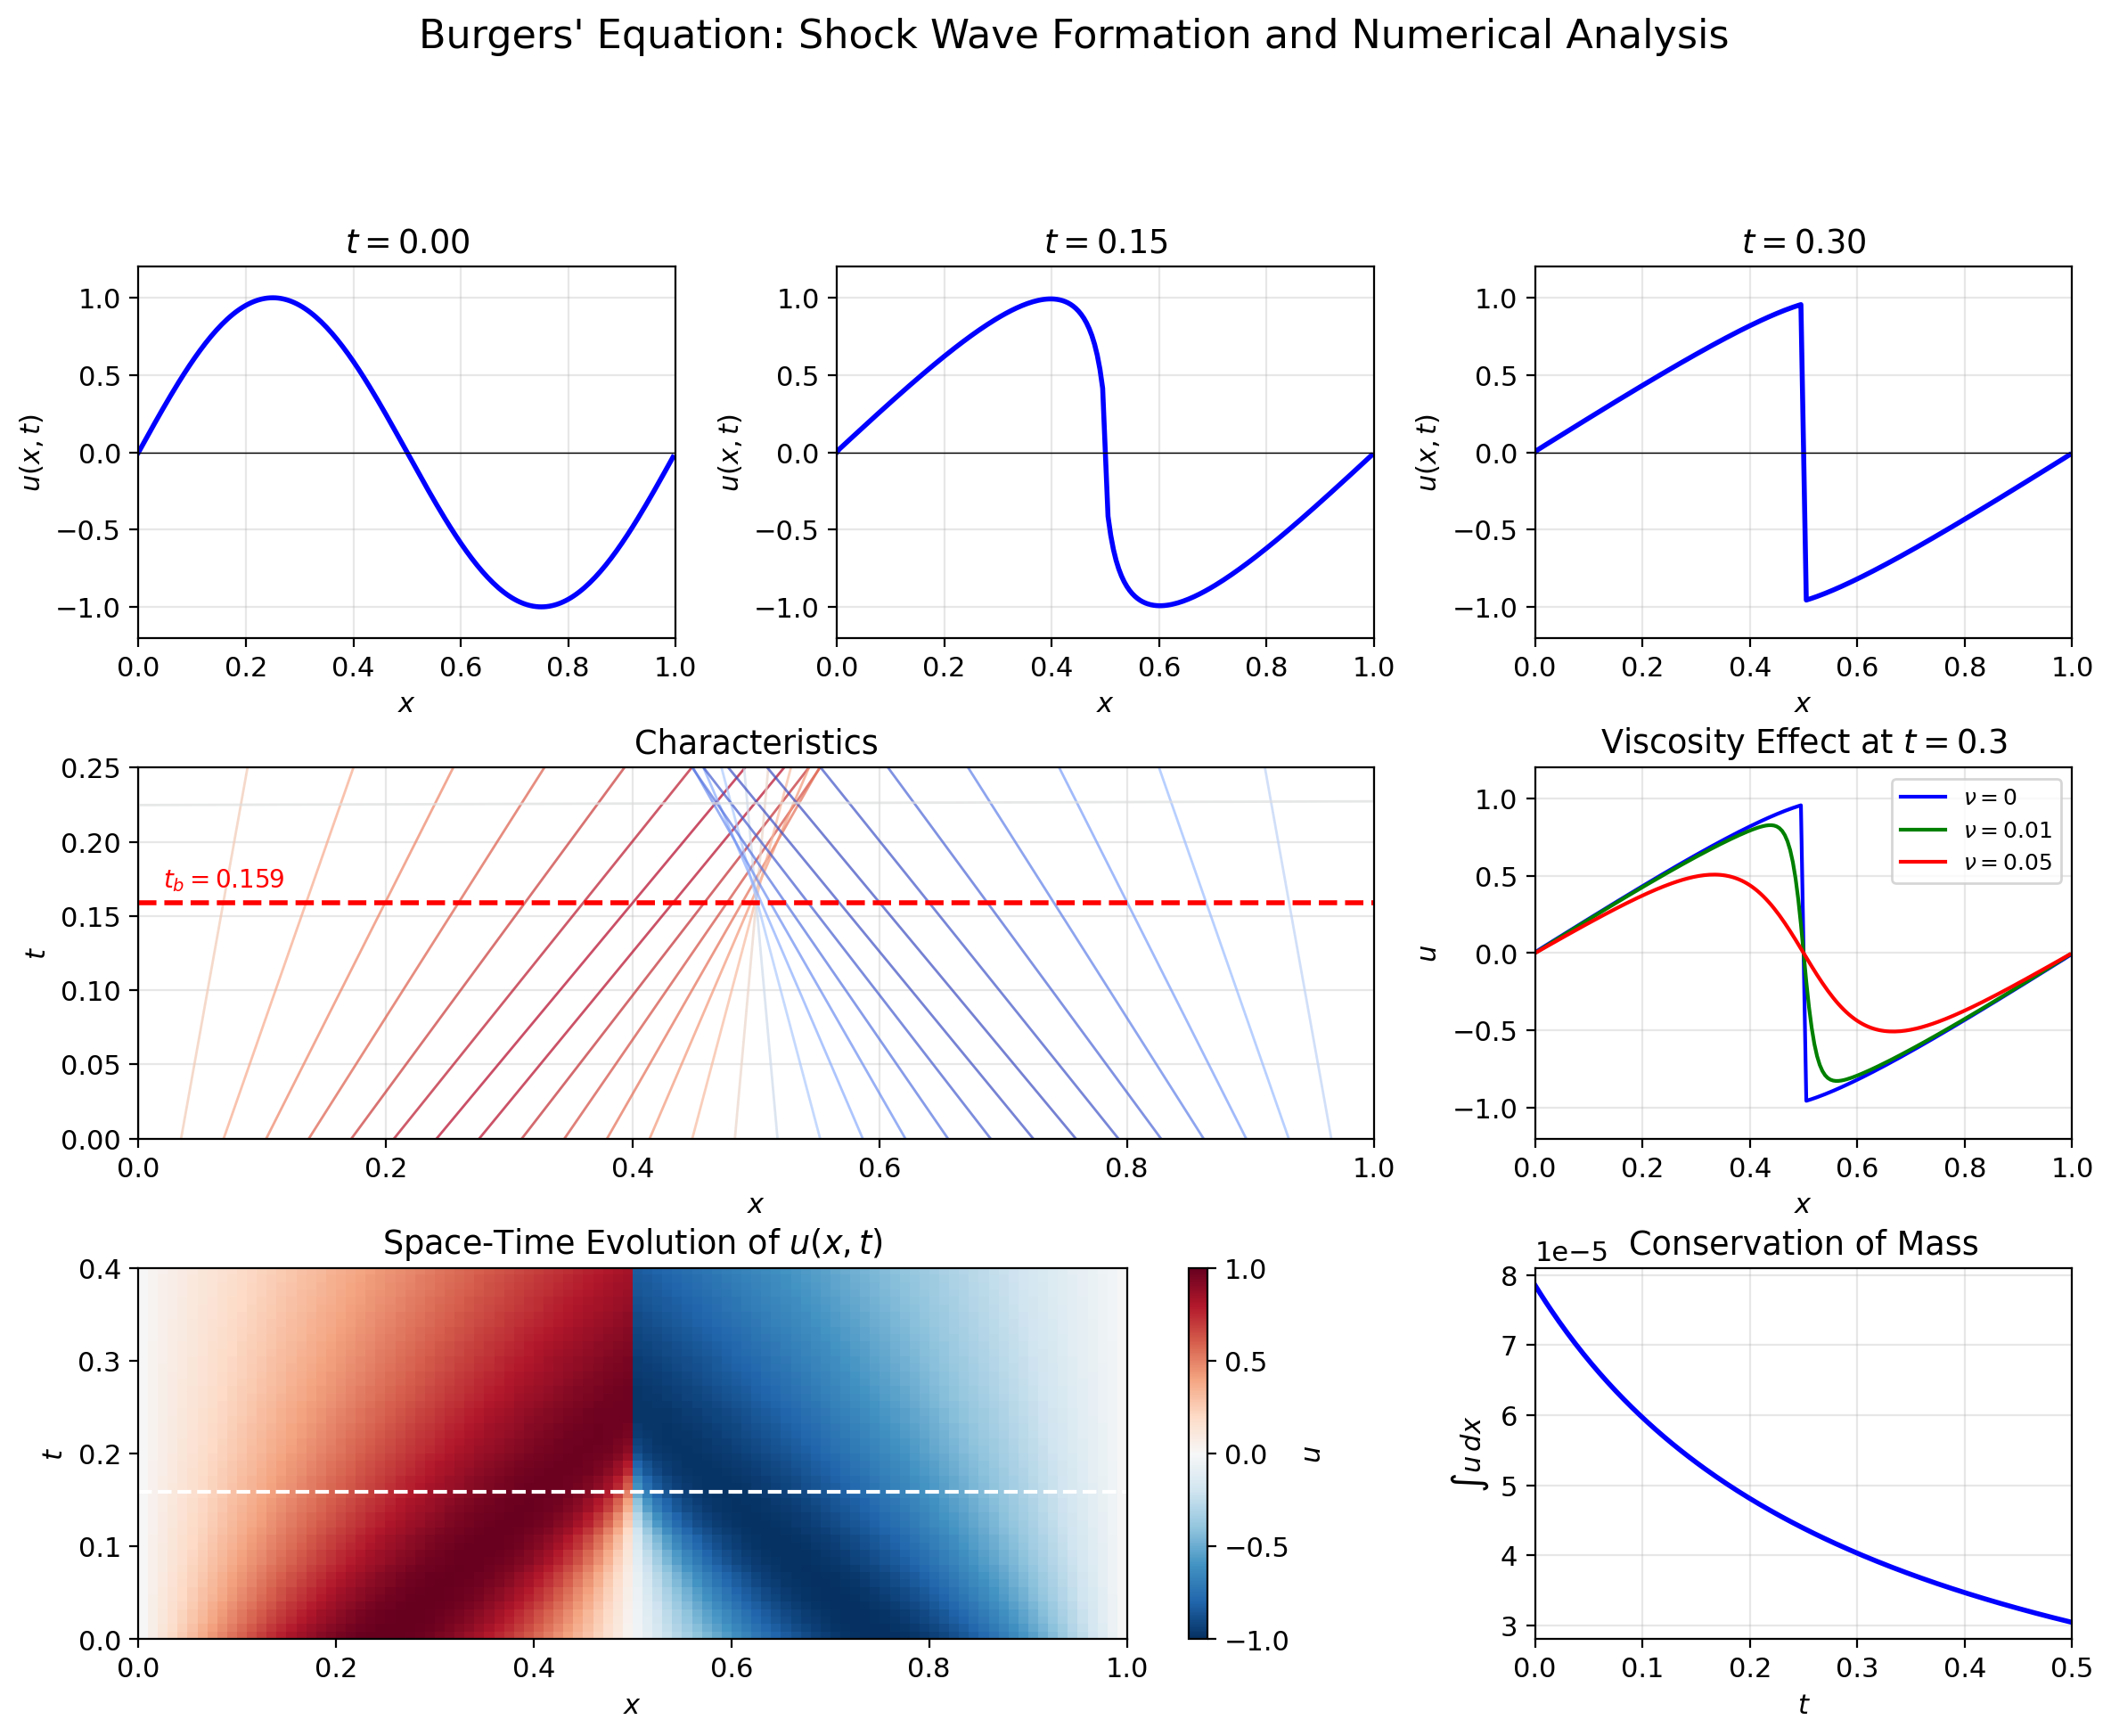

Figure saved to plot.png


In [12]:
# Create comprehensive final figure
fig = plt.figure(figsize=(14, 10))

# Grid specification for custom layout
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Top row: Solution evolution
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

plot_times_top = [0, 0.15, 0.3]
for ax, t_plot in zip([ax1, ax2, ax3], plot_times_top):
    i = np.argmin([abs(t - t_plot) for t in times_inv])
    ax.plot(x, solutions_inv[i], 'b-', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x, t)$')
    ax.set_title(f'$t = {times_inv[i]:.2f}$')
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    ax.grid(True, alpha=0.3)

# Middle left: Characteristics
ax4 = fig.add_subplot(gs[1, 0:2])
for i in range(n_chars):
    t_plot = np.linspace(0, 0.25, 100)
    x_char = (x0_chars[i] + u0_chars[i] * t_plot) % 1.0
    color = plt.cm.coolwarm((u0_chars[i] + 1) / 2)
    ax4.plot(x_char, t_plot, '-', color=color, linewidth=1, alpha=0.7)

ax4.axhline(y=t_break, color='red', linestyle='--', linewidth=2)
ax4.text(0.02, t_break + 0.01, f'$t_b = {t_break:.3f}$', color='red', fontsize=10)
ax4.set_xlabel('$x$')
ax4.set_ylabel('$t$')
ax4.set_title('Characteristics')
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 0.25])
ax4.grid(True, alpha=0.3)

# Middle right: Viscosity comparison
ax5 = fig.add_subplot(gs[1, 2])
viscosities_plot = [0, 0.01, 0.05]
colors = ['blue', 'green', 'red']
for nu, color in zip(viscosities_plot, colors):
    _, sols = simulate_burgers(u0, dx, 0.3, nu=nu)
    ax5.plot(x, sols[-1], color=color, linewidth=1.5, label=f'$\\nu = {nu}$')

ax5.set_xlabel('$x$')
ax5.set_ylabel('$u$')
ax5.set_title('Viscosity Effect at $t = 0.3$')
ax5.legend(fontsize=9)
ax5.set_xlim([0, 1])
ax5.set_ylim([-1.2, 1.2])
ax5.grid(True, alpha=0.3)

# Bottom row: Riemann problems
ax6 = fig.add_subplot(gs[2, 0:2])

# Space-time plot
N_st = 100
x_st = np.linspace(0, 1, N_st)
dx_st = x_st[1] - x_st[0]
t_vals = np.linspace(0, 0.4, 50)
u_st = np.zeros((len(t_vals), N_st))
u_st[0, :] = initial_condition(x_st)

# Simple simulation for space-time plot
u_current = initial_condition(x_st)
t = 0
t_idx = 1
while t_idx < len(t_vals):
    u_max = max(np.max(np.abs(u_current)), 0.1)
    dt = 0.5 * dx_st / u_max
    u_current = godunov(u_current, dx_st, dt)
    t += dt
    
    if t >= t_vals[t_idx]:
        u_st[t_idx, :] = u_current
        t_idx += 1

im = ax6.imshow(u_st, extent=[0, 1, 0, 0.4], aspect='auto', 
                origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
ax6.axhline(y=t_break, color='white', linestyle='--', linewidth=1.5)
ax6.set_xlabel('$x$')
ax6.set_ylabel('$t$')
ax6.set_title('Space-Time Evolution of $u(x,t)$')
plt.colorbar(im, ax=ax6, label='$u$')

# Bottom right: Conservation check
ax7 = fig.add_subplot(gs[2, 2])

# Calculate integral over time
T_cons = 0.5
u_cons = u0.copy()
t = 0
times_cons = [0]
integrals = [np.trapz(u_cons, x)]

while t < T_cons:
    u_max = max(np.max(np.abs(u_cons)), 0.1)
    dt = 0.5 * dx / u_max
    if t + dt > T_cons:
        dt = T_cons - t
    u_cons = godunov(u_cons, dx, dt)
    t += dt
    times_cons.append(t)
    integrals.append(np.trapz(u_cons, x))

ax7.plot(times_cons, integrals, 'b-', linewidth=2)
ax7.set_xlabel('$t$')
ax7.set_ylabel('$\\int u \\, dx$')
ax7.set_title('Conservation of Mass')
ax7.grid(True, alpha=0.3)
ax7.set_xlim([0, T_cons])

plt.suptitle("Burgers' Equation: Shock Wave Formation and Numerical Analysis", 
             fontsize=16, y=1.02)

plt.tight_layout()

# Save the figure
plt.savefig('burgers_equation_shock_waves_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figure saved to plot.png")

## Conclusions

This notebook has demonstrated the fundamental properties of Burgers' equation:

1. **Shock Formation**: The nonlinear advection term causes smooth initial conditions to steepen and form discontinuities (shocks) at the breaking time $t_b = 1/(2\pi)$ for sinusoidal initial data.

2. **Method of Characteristics**: Characteristics are straight lines that converge where $du_0/dx < 0$, leading to multi-valued solutions that must be resolved as shocks.

3. **Rankine-Hugoniot Condition**: Shocks propagate at speed $s = (u_L + u_R)/2$, ensuring conservation of mass across the discontinuity.

4. **Viscosity Effects**: Adding viscosity $\nu > 0$ smooths the shock, with larger viscosity creating wider transition regions. In the limit $\nu \to 0$, we recover the inviscid solution.

5. **Numerical Methods**: The Godunov scheme provides sharp shock resolution through exact Riemann solvers, while Lax-Friedrichs is more diffusive but simpler to implement.

6. **Riemann Problems**: The fundamental building blocks for understanding nonlinear wave propagation—shocks form when $u_L > u_R$ and rarefactions when $u_L < u_R$.

Burgers' equation serves as an essential model problem for developing and testing numerical methods for conservation laws before applying them to more complex systems like the Euler equations of gas dynamics.